# The Modern House Premium

[The Modern House](https://www.themodernhouse.com) is a niche real estate agent that lists only architecturally unique homes for sale. The listings are tastefully presented with professional photos and introduction into the architecture history of the building. As such, the website claims that they are able to achieve a 12% premium in selling prices compared with other real estate agencies. 

<img src="dataloft.png" alt="claim" width="300" height="200"/>

I attempt to verify this claim through a webscraping exercise. To do this, I scrape Modern House's current listing prices, address and number of bedrooms from their website. I then use the Zoopla API to download price information of other house for sale around 0.5 mile radius of the Modern House listings to get a sense of average selling price of the neighbourhood. I then compare to see if the Modern House listings do actually have a premium price listing compared to its neighbours. 


In [1]:
#Importing all the packages that will be used
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #Ignore package warnings
import os

#Webscraping tools
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
import re
from zoopla import Zoopla
import time

#Data analysis
import pandas as pd
import numpy as np

#Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

## Data collection

### 1. Webscraping The Modern House website using Selenium & Beautiful Soup

The modern house url ends with all the houses on sale for a specific number of bedrooms. Ideally, I would need the per square meter prices of a property. However, this information is only available in the form of floor plan which is in a PDF image. The closest approximation to the size would be number of bedrooms. My strategy is to create functions to scroll through the website and collect data. This is then repeated for all the pages for different number of bedrooms. 

In [2]:
#Webscraping url - The Modern House

##Build a function to scroll down the pages to the end and extract page source using Chrome 
def scrollExtractChrome(url):
  
    #Using the chrome driver
    chrome_path = os.getcwd() + '/chromedriver'
    browser = webdriver.Chrome(chrome_path)

    # Tell Selenium to get the URL you're interested in.
    browser.get(url)

    # Selenium script to scroll to the bottom, wait 3 seconds for the next batch of data to load, then continue scrolling. It will continue to do this until the page stops loading new data.
    lenOfPage = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    match=False
    while(match==False):
        lastCount = lenOfPage
        time.sleep(3)
        lenOfPage = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        if lastCount==lenOfPage:
            match=True

    # Now that the page is fully scrolled, grab the source code.
    return browser.page_source

    
##Define a function to extract data from the page source using a specific regex pattern
def extractFromXML(page,tag,tag_class,pattern):
    #Create BeautifulSoup object
    soup = BeautifulSoup(page,'lxml')

    #Filter all the entries
    rows= soup.find_all(tag,attrs={'class':tag_class})

    #Use the regex pattern to extract data needed
    attributes=[re.findall(pattern, i.prettify()) for i in rows]

    #Flatten out row list for easy import into pandas
    return [item for sublist in attributes for item in sublist]



In [3]:
#Define parameters for the functions made above
url = "https://www.themodernhouse.com/sales-list/homes/all/"
pattern_location = "<h3 class=\"listing-name\">\\n\s+(?P<name>.*)\\n\s+<br/>\\n\s+(?P<postcode>.*)\\n</h3>\\n"
pattern_price = "<div class=\"listing-price\">\\n\s+(?P<price>£.*)\\n\s+<br/>\\n\s+(?P<hold>.*)\\n</div>"

#Compile all the information downloaded into a dataframe
df = pd.DataFrame()
for i in range(1,6):
    link = url + str(i)
    #Extract data using the defined functions:
    page = scrollExtractChrome(link)
    location_extract = extractFromXML(page,'h3', 'listing-name', pattern_location)
    price_extract = extractFromXML(page,'div', 'listing-price', pattern_price)
    
    #Join two datasets together and import to pandas
    data = [a+b for a,b in zip(location_extract,price_extract)]
    labels = ['address','postcode','price','hold']
    df_part = pd.DataFrame.from_records(data, columns=labels)
    df_part['bedrooms'] = i
    df = df.append(df_part)
    

In [4]:
df = df.reset_index(drop=True)
df.head(20)

,address,postcode,price,hold,bedrooms
0,St John Street,London EC1,"£2,275,000",Leasehold,1
1,St Agnes Close,London E9,"£900,000",Leasehold,1
2,Faversham II,Kent,"£825,000",Leasehold,1
3,Gloucester Terrace,London W2,"£825,000",Freehold,1
4,Epirus Road,London SW6,"£695,000",Leasehold,1
...,...,...,...,...,...
15,Morris Road,London E14,"£1,175,000",Share of Freehold,2
16,Hackney Road,London E2,"£1,100,000",Share of Freehold,2
17,Britannia Wharf,"Baldwin Terrace, London N1","£1,100,000",Freehold,2
18,Glenshaw Mansions,"Priory Road, London NW6","£1,050,000",Leasehold,2


### Data cleaning for the Modern House price data

The main problems are:
1. Changing price data to numeric
2. Parts of the address data is within the postcode column: Need to split out the address into building, block, street, postcode and area

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
address     110 non-null object
postcode    110 non-null object
price       110 non-null object
hold        110 non-null object
bedrooms    110 non-null int64
dtypes: int64(1), object(4)
memory usage: 4.4+ KB


In [6]:
#Data cleaning

#change price to numeric
df['price'] = pd.to_numeric(df['price'].replace('[\D]','',regex=True))
#separate out postcode column with further details of address
postcode_split1=df['postcode'].str.split(',',expand=True)
postcode_split1.head(20)
#The problem is that address information isn't uniform across all listings. Some have building names and some don't.
#Require another function to push last non-blank information to the last column. 

,0,1,2
0,London EC1,None,None
1,London E9,None,None
2,Kent,None,None
3,London W2,None,None
4,London SW6,None,None
...,...,...,...
15,London E14,None,None
16,London E2,None,None
17,Baldwin Terrace,London N1,None
18,Priory Road,London NW6,None


In [7]:
def pushLastColumn(df):
    
    n = df.shape
    
    #Find rows that already have values in all columns or no values at all: we can ignore
    fixed = [i for i,v in enumerate(df.notnull().all(axis=1)) if v == True]
    empty = [i for i,v in enumerate(df.isnull().all(axis=1)) if v == True]
    exceptions = fixed + empty
    
    #Find all the position where the figures should move
    i = np.where(df.notnull())
    #Those in the exception rows doesn't need to move
    boolean_filter= [False if x in exceptions else True for x in i[0]]
    #Move the last value in each row
    i_last = pd.Index(i[0]).duplicated(keep='last')
    dat_loc = [not i for i in i_last]
    dat_loc = np.logical_and(dat_loc, boolean_filter)
    #Get the iloc locations of all the figures that should move
    fromloc = list(zip(i[0][dat_loc],i[1][dat_loc]))    
   
    #Find the location of all the NaN
    j = np.where(df.isnull())
    #Find the location where the NaN should be filled in last columns
    boolean_filter= [False if x in exceptions else True for x in j[0]]
    j_last = pd.Index(j[0]).duplicated(keep='last')
    fill_loc = [not i for i in j_last]
    fill_loc = np.logical_and(fill_loc, boolean_filter)
    toloc = list(zip(j[0][fill_loc],j[1][fill_loc]))
        
    #update dataframe by shifting cell positions
    l = len(fromloc)
    for x in range(l):
        df.iloc[toloc[x][0],toloc[x][1]] = df.iloc[fromloc[x][0],fromloc[x][1]]
        df.iloc[fromloc[x][0],fromloc[x][1]] = np.nan
    
    return df



In [8]:
postcode_split2 = pushLastColumn(postcode_split1)
postcode_split2.rename(columns = {0:'building', 1:'street', 2:'area'}, inplace=True)
postcode_split2.head(20)


,building,street,area
0,NaN,None,London EC1
1,NaN,None,London E9
2,NaN,None,Kent
3,NaN,None,London W2
4,NaN,None,London SW6
...,...,...,...
15,NaN,None,London E14
16,NaN,None,London E2
17,Baldwin Terrace,NaN,London N1
18,Priory Road,NaN,London NW6


In [9]:
#We still have a third part of address not contained in the initial postcode 
address_parts = pd.concat([df.loc[:,'address'],postcode_split2.drop(['area'], axis=1)], axis=1)
address_parts.head(20)
#We want to push and collect all the first parts to the streets column

,address,building,street
0,St John Street,NaN,None
1,St Agnes Close,NaN,None
2,Faversham II,NaN,None
3,Gloucester Terrace,NaN,None
4,Epirus Road,NaN,None
...,...,...,...
15,Morris Road,NaN,None
16,Hackney Road,NaN,None
17,Britannia Wharf,Baldwin Terrace,NaN
18,Glenshaw Mansions,Priory Road,NaN


In [10]:
address_parts = pushLastColumn(address_parts)
address_parts.rename(columns={'address':'building','building':'block'}, inplace=True)
address_parts.head(20)

,building,block,street
0,NaN,NaN,St John Street
1,NaN,NaN,St Agnes Close
2,NaN,NaN,Faversham II
3,NaN,NaN,Gloucester Terrace
4,NaN,NaN,Epirus Road
...,...,...,...
15,NaN,NaN,Morris Road
16,NaN,NaN,Hackney Road
17,Britannia Wharf,NaN,Baldwin Terrace
18,Glenshaw Mansions,NaN,Priory Road


In [11]:
#Further split postcode into area and actual postcode
area_postcode=pd.DataFrame()
area_postcode[['area','postcode']]=postcode_split2['area'].str.strip().str.split(' ', expand = True)
area_postcode.head()

,area,postcode
0,London,EC1
1,London,E9
2,Kent,None
3,London,W2
4,London,SW6


In [12]:
#Combining all the different parts of the address and original data
data = pd.concat([address_parts,area_postcode,df.drop(['postcode','address'],axis=1)], axis=1)
data.head()

,building,block,street,area,postcode,price,hold,bedrooms
0,NaN,NaN,St John Street,London,EC1,2275000,Leasehold,1
1,NaN,NaN,St Agnes Close,London,E9,900000,Leasehold,1
2,NaN,NaN,Faversham II,Kent,None,825000,Leasehold,1
3,NaN,NaN,Gloucester Terrace,London,W2,825000,Freehold,1
4,NaN,NaN,Epirus Road,London,SW6,695000,Leasehold,1


In [13]:
data.to_csv('modernhousedata.csv')

### Visual exploration of the modern home dataset

In [14]:
#Create a category dummy
data['london_dummy'] = ['Inside London' if i == 'London' else 'Outside London' for i in data['area']]

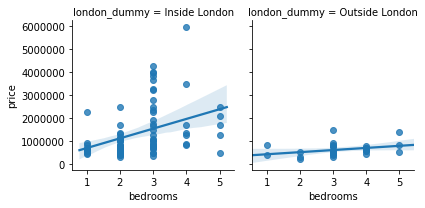

In [15]:
#A quick visualisation to ensure that the price data makes sense -- 
#The larger the number of bedrooms, the higher the price

g = sns.FacetGrid(data, col='london_dummy')
g.map(sns.regplot, 'bedrooms','price')

#Can see that there is a much steeper line for london which is expected. 

## Data collection

### 2. Download neighbourhood price data from Zoopla API

In [16]:
#Get data from Zoopla API
from zoopla import Zoopla
import time

zoopla = Zoopla(api_key='uu33d4ea2wsdkncap2xmd4rp')


def getdata(address,town):
    try:
        search = zoopla.property_listings({
            'radius':'0.5',
            'listing_status': 'sale',
            'area': address,
            'town': town
        })
        return [(address,town,i.latitude,i.longitude,i.price,i.num_bedrooms, i.agent_name) for i in search.listing]
    except Exception as e:
        return []

In [17]:
#Number of calls needed

#The limit is 100 calls per 60minutes => Each call interval should be around 36seconds
zoopla_data = []
for i in list(zip(data.loc[:,'street'], data.loc[:,'area'])):
    x=getdata(i[0],i[1]) #get data from zoopla
    x=[item+(i[0],)+(i[1],) for item in x ] #append search street and area
    #time.sleep(36)
    zoopla_data = zoopla_data + x

In [18]:
cols = ['address','town','latitude','longitude','price','bedrooms','agent','search_street','search_area']
zoopla_df = pd.DataFrame(zoopla_data, columns=cols)
#zoopla_df.to_csv('zoopla_df.csv')

In [19]:
df = pd.read_csv('zoopla_df.csv')
df.head()

,Unnamed: 0,address,town,latitude,longitude,price,bedrooms,agent,search_street,search_area
0,0,Epirus Road,London,51.478540,-0.191796,7500000.0,5,Aylesford International,Epirus Road,London
1,1,Epirus Road,London,51.482910,-0.197614,6500000.0,6,UK Sotheby's International Realty - London,Epirus Road,London
2,2,Epirus Road,London,51.482910,-0.197614,3850000.0,4,John D Wood & Co. - Fulham Broadway Sales,Epirus Road,London
3,3,Epirus Road,London,51.477135,-0.205733,3725000.0,5,Keller Williams Prime Properties,Epirus Road,London
4,4,Epirus Road,London,51.479687,-0.199628,3000000.0,10,Keller Williams Prime Properties,Epirus Road,London


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 10 columns):
Unnamed: 0       477 non-null int64
address          477 non-null object
town             477 non-null object
latitude         477 non-null float64
longitude        477 non-null float64
price            477 non-null float64
bedrooms         477 non-null int64
agent            477 non-null object
search_street    477 non-null object
search_area      477 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 37.3+ KB


### Data cleaning for Zoopla data set

In [22]:
#Remove first unnamed column
longdata = df.drop(list(df)[0],axis=1)

In [23]:
#Remove any listing from The Modern House
filter_mh = longdata.loc[:,'agent'].str.contains('The Modern House')
neighbourhood = longdata[[not i for i in filter_mh]]
neighbourhood = neighbourhood.reset_index(drop=True)
neighbourhood.head()

,address,town,latitude,longitude,price,bedrooms,agent,search_street,search_area
0,Epirus Road,London,51.478540,-0.191796,7500000.0,5,Aylesford International,Epirus Road,London
1,Epirus Road,London,51.482910,-0.197614,6500000.0,6,UK Sotheby's International Realty - London,Epirus Road,London
2,Epirus Road,London,51.482910,-0.197614,3850000.0,4,John D Wood & Co. - Fulham Broadway Sales,Epirus Road,London
3,Epirus Road,London,51.477135,-0.205733,3725000.0,5,Keller Williams Prime Properties,Epirus Road,London
4,Epirus Road,London,51.479687,-0.199628,3000000.0,10,Keller Williams Prime Properties,Epirus Road,London


### Exploratory visualisation of Zoopla data

In [24]:
#Turn CSV into a Point geomatry (Point GeoDataFrame) with WSG84 Coordinate Reference System
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs = {'init': 'epsg:4326'}
houses = GeoDataFrame(df, crs=crs, geometry=geometry)
#Edit first column name
houses.columns.values[0] = "objectid"
houses.head()

,objectid,address,town,latitude,longitude,price,bedrooms,agent,search_street,search_area,geometry
0,0,Epirus Road,London,51.478540,-0.191796,7500000.0,5,Aylesford International,Epirus Road,London,POINT (-0.191796 51.47854)
1,1,Epirus Road,London,51.482910,-0.197614,6500000.0,6,UK Sotheby's International Realty - London,Epirus Road,London,POINT (-0.197614 51.48291)
2,2,Epirus Road,London,51.482910,-0.197614,3850000.0,4,John D Wood & Co. - Fulham Broadway Sales,Epirus Road,London,POINT (-0.197614 51.48291)
3,3,Epirus Road,London,51.477135,-0.205733,3725000.0,5,Keller Williams Prime Properties,Epirus Road,London,POINT (-0.205733 51.477135)
4,4,Epirus Road,London,51.479687,-0.199628,3000000.0,10,Keller Williams Prime Properties,Epirus Road,London,POINT (-0.199628 51.479687)


In [25]:
#Create two subsets of the data: one for ModernHouse houses and one for all other agents:
mh_filter = houses.loc[:,'agent'].str.contains('The Modern House')
reverse = [not i for i in mh_filter]
modernhouse = houses[mh_filter].reset_index(drop=True)
otherhouse = houses[reverse].reset_index(drop=True)

In [26]:
#Create a list of locations for both datasets:
locationlistMH = modernhouse[['latitude', 'longitude']].values.tolist()

locationlistOthers = otherhouse[['latitude', 'longitude']].values.tolist()


In [28]:
from folium.plugins import MarkerCluster

#Create the basemap
map2 = folium.Map(location=[51.5, -0.10], tiles='CartoDB dark_matter', zoom_start=11)

#Create a cluster of Modern House points in Red
ClusterMH = folium.plugins.MarkerCluster().add_to(map2)
for point in range(0, len(locationlistMH)):
    folium.Marker(locationlistMH[point], popup=modernhouse['agent'][point], 
                  icon=folium.Icon(color='red', prefix='fa', icon='home')).add_to(ClusterMH)

#Create a cluster of Other house points in Green
ClusterOthers = folium.plugins.MarkerCluster().add_to(map2)
for point in range(0, len(locationlistOthers)):
    folium.Marker(locationlistOthers[point], popup=otherhouse['agent'][point], 
                  icon=folium.Icon(color='green', prefix='fa', icon='home')).add_to(ClusterOthers)
#Plot the map
map2

## Data analysis - Finding the price premium

In [30]:
#Get the mean house price for each street and type of bedroom
#Compare this with The Modern House's prices
g=pd.DataFrame(neighbourhood.groupby(['search_street','bedrooms']).price.mean(), columns = ['price'])
combinedata = pd.merge(data, g, how = 'inner', left_on=['street','bedrooms'], right_index=True).reset_index(drop=True)
combinedata.head()

,building,block,street,area,postcode,price_x,hold,bedrooms,london_dummy,price_y
0,The Haptic Apartment,Televison Centre,Wood Lane,London,W12,2500000,Leasehold,2,Inside London,2.933333e+05
1,NaN,NaN,Ravey Street,London,EC2,1325000,Leasehold,2,Inside London,5.425000e+06
2,NaN,NaN,"Godolphin Road, A",London,W12,699950,Freehold,2,Inside London,4.300000e+05
3,Bruno Court II,NaN,Fassett Square,London,E8,635000,Share of Freehold,2,Inside London,1.500000e+06
4,Keeling House V,NaN,Claredale Street,London,E2,590000,Leasehold,2,Inside London,1.035000e+06


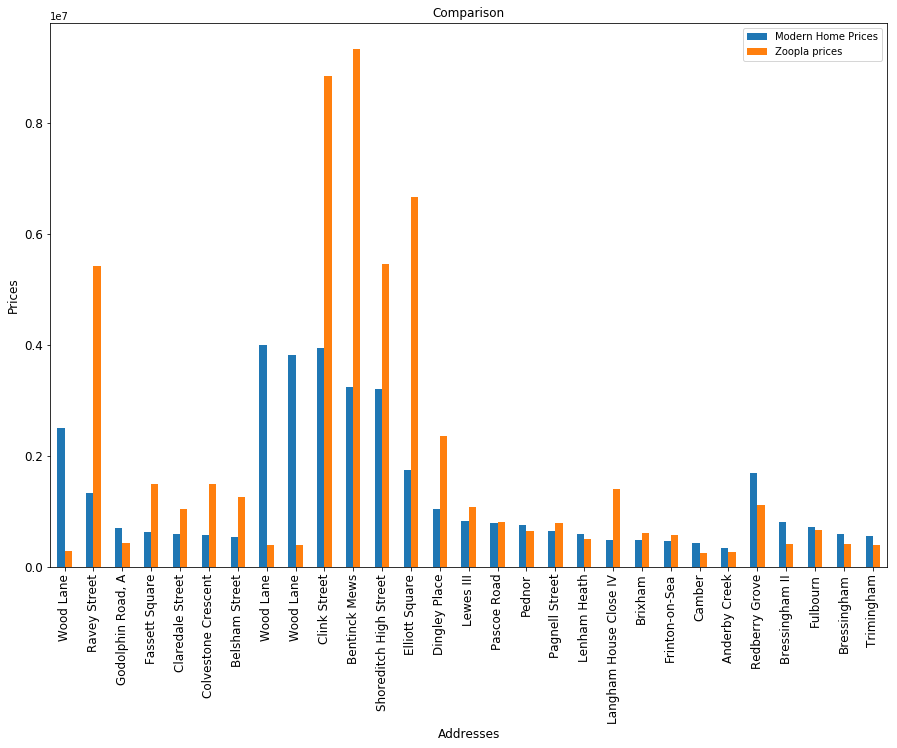

In [31]:
#Plot an inital comparison between Modern House price and Zoopla prices
ax = combinedata.set_index('street')[['price_x','price_y']].plot(kind='bar', \
                    title ="Comparison", figsize=(15, 10), legend=True, fontsize=12, use_index=True)
ax.set_xlabel("Addresses", fontsize=12)
ax.set_ylabel("Prices", fontsize=12)
ax.legend(('Modern Home Prices','Zoopla prices'))
plt.show()

In [32]:
#filter out differences higher than 50% as this is likely to be driven by differences in square meters
combinedata['price_difference'] = combinedata['price_x'] - combinedata['price_y']
combinedata['lower_price'] = combinedata[['price_x','price_y']].min(axis=1)
combinedata2 = combinedata[(combinedata['price_difference'].abs()/combinedata['lower_price'])<0.5].reset_index(drop=True)
combinedata2
#I get a really small sample to make the right comparison

,building,block,street,area,postcode,price_x,hold,bedrooms,london_dummy,price_y,price_difference,lower_price
0,NaN,NaN,Lewes III,East,Sussex,820000,Freehold,3,Outside London,1.075000e+06,-255000.000000,820000.000000
1,NaN,NaN,Pascoe Road,London,SE13,795000,Freehold,3,Inside London,8.000000e+05,-5000.000000,795000.000000
2,NaN,NaN,Pednor,Buckinghamshire,None,749000,Freehold,3,Outside London,6.500000e+05,99000.000000,650000.000000
3,New Cross Lofts,NaN,Pagnell Street,London,SE14,650000,Share of Freehold,3,Inside London,7.833333e+05,-133333.333333,650000.000000
4,The Cowshed,NaN,Lenham Heath,Kent,None,585000,Freehold,3,Outside London,5.056250e+05,79375.000000,505625.000000
5,Parkham Wood House II,NaN,Brixham,Devon,None,475000,Freehold,3,Outside London,6.075000e+05,-132500.000000,475000.000000
6,Quendon Way,NaN,Frinton-on-Sea,Essex,None,465000,Freehold,3,Outside London,5.750000e+05,-110000.000000,465000.000000
7,NaN,NaN,Anderby Creek,Lincolnshire,None,330000,Freehold,3,Outside London,2.650000e+05,65000.000000,265000.000000
8,NaN,NaN,Fulbourn,Cambridge,None,710000,Freehold,4,Outside London,6.625000e+05,47500.000000,662500.000000
9,NaN,NaN,Bressingham,Norfolk,None,599000,Freehold,4,Outside London,4.200000e+05,179000.000000,420000.000000


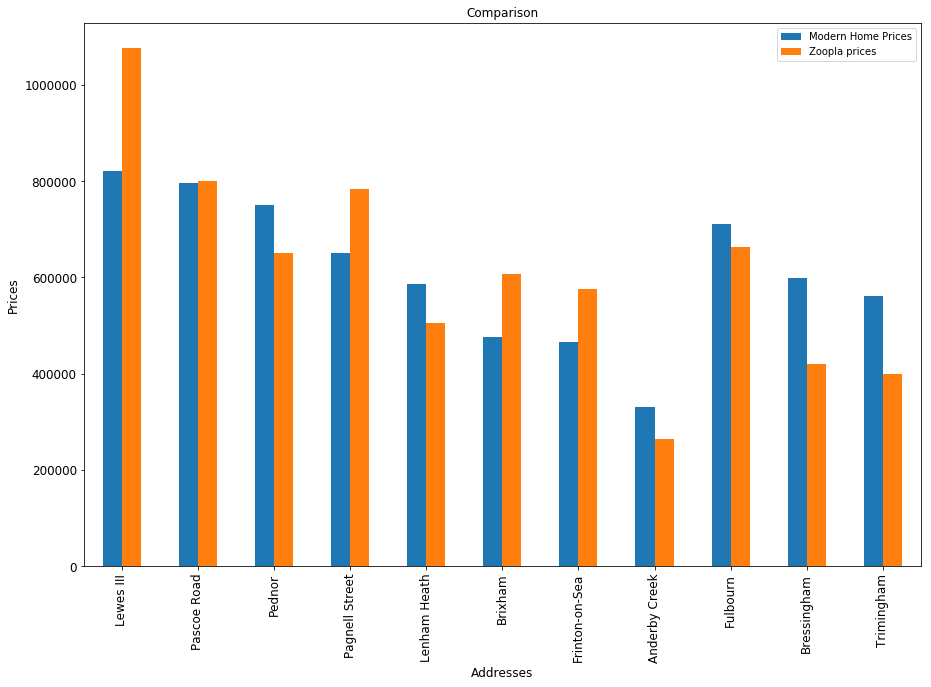

In [33]:
#Plotting the filtered list to compare
ax = combinedata2.set_index('street')[['price_x','price_y']].plot(kind='bar', \
                    title ="Comparison", figsize=(15, 10), legend=True, fontsize=12, use_index=True)
ax.set_xlabel("Addresses", fontsize=12)
ax.set_ylabel("Prices", fontsize=12)
ax.legend(('Modern Home Prices','Zoopla prices'))
plt.show()

#No reason to say that Modern House Prices have a premium over its neighbours

In [34]:
#Have a sense of the premium over Zoopla prices
combinedata2['premium']=combinedata2['price_difference']/combinedata2['price_y']

In [35]:
combinedata2['premium'].describe() #Doesn't seem to have any premium

count    11.000000
mean      0.057749
std       0.243366
min      -0.237209
25%      -0.180759
50%       0.071698
75%       0.201133
max       0.426190
Name: premium, dtype: float64

In [38]:
#Perform a formal statistical test for a paired list 
from scipy import stats
stats.wilcoxon(combinedata2['price_difference']) 
#Do not reject that there is a price difference

WilcoxonResult(statistic=33.0, pvalue=1.0)

## Conclusion and results

- The main limitations of my approach is from the Zoopla API which is ill-maintained. The API key expires after a day of usage and hence not alot of data could be collected. Future work could include direct scraping from the Zoopla website itself. 

- The other main limitation is that my result tries to compare like-for-like for number of bedrooms. However, there is quite a large variation regarding actual floor size of the houses even within two bedroom flats. A better analysis requires us to calculate per square foot price of houses. 

**From the limited dataset for comparison, I found that there isn't enough evidence to say that Modern House is able to charge a premium on its listings.** 